In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf

from tensorflow.keras.constraints import MinMaxNorm

sns.set_context('notebook', font_scale=1.5)

In [2]:
hour = pd.read_csv('hour.csv')

In [3]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
hour.shape

(17379, 17)

In [5]:
hour['dteday'] = pd.to_datetime(hour['dteday'])

In [6]:
hour['day'] = hour['dteday'].dt.day

In [7]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [8]:
hour.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

In [9]:
hour.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,1
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,1
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,1
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1


In [10]:
hour.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
day           0
dtype: int64

In [11]:
hour.duplicated().sum()

0

In [12]:
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
 13  day         17379 non-null  int32  
dtypes: float64(4), int32(1), int64(9)
memory usage: 1.8 MB


### Split

In [35]:
normalization = tf.keras.constraints.MinMaxNorm(min_value=0, max_value=1)

In [31]:
X = hour.drop(columns=['cnt'])
y = hour['cnt']
minmax = MinMaxScaler(feature_range=(0, 1))

In [57]:
X_train = X.sample(frac=.8, random_state=0)
y_train = y.sample(frac=.8, random_state=0)
X_test = X.drop(X_train.index)
y_test = y.drop(y_train.index)

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13903, 13)
(13903,)
(3476, 13)
(3476,)


In [ ]:
normalization.

### Model with Neural Networks - Linear Regression - Baseline

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='relu', input_shape=[X_train.shape[1]]),
        tf.keras.layers.Dense(1)
    ])

model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=['mse'],
        metrics=["mae"],
    )


In [ ]:
model.build()

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=.2, verbose=1)

In [ ]:
def plot_loss():
    plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


In [ ]:
plot_loss()

In [ ]:
def plot_mae():
    plt.figure(figsize=(10,7))
    plt.plot(history.history['mae'], label='Training (MAE)')
    plt.plot(history.history['val_mae'], label='Validation (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)


In [ ]:
plot_mae()

### Model Linear Regression  - Fine Tuning 

In [69]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()
y_train = (y_train - y_train.mean()) / y_train.std()
y_test = (y_test - y_test.mean()) / y_test.std()

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=['mse'],
              metrics=['mae'])

In [91]:
model.build()

In [92]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 13)                52        
 chNormalization)                                                
                                                                 
 dense_56 (Dense)            (None, 2048)              28672     
                                                                 
 dense_57 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_58 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_59 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_60 (Dense)            (None, 1)                 2049      
                                                     

In [95]:
history = model.fit(X_train, y_train, epochs=100, validation_split=.2)

Epoch 1/100
348/348 [==============================] - 5s 10ms/step - loss: 0.7129 - mae: 0.6974 - val_loss: 0.7886 - val_mae: 0.7504
Epoch 2/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6453 - mae: 0.6672 - val_loss: 0.6425 - val_mae: 0.6546
Epoch 3/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6161 - mae: 0.6546 - val_loss: 0.5899 - val_mae: 0.6343
Epoch 4/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6201 - mae: 0.6579 - val_loss: 0.5697 - val_mae: 0.6411
Epoch 5/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6007 - mae: 0.6468 - val_loss: 0.5635 - val_mae: 0.6209
Epoch 6/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6022 - mae: 0.6439 - val_loss: 0.5686 - val_mae: 0.6285
Epoch 7/100
348/348 [==============================] - 4s 10ms/step - loss: 0.5882 - mae: 0.6392 - val_loss: 0.5315 - val_mae: 0.6118
Epoch 8/100
348/348 [==============================] - 4s 10ms

Epoch 62/100
348/348 [==============================] - 4s 10ms/step - loss: 0.4980 - mae: 0.5876 - val_loss: 0.5066 - val_mae: 0.5986
Epoch 63/100
348/348 [==============================] - 4s 10ms/step - loss: 0.4989 - mae: 0.5855 - val_loss: 0.5134 - val_mae: 0.6050
Epoch 64/100
348/348 [==============================] - 3s 10ms/step - loss: 0.5080 - mae: 0.5913 - val_loss: 0.5174 - val_mae: 0.6049
Epoch 65/100
348/348 [==============================] - 4s 10ms/step - loss: 0.5043 - mae: 0.5876 - val_loss: 0.5190 - val_mae: 0.5985
Epoch 66/100
348/348 [==============================] - 4s 10ms/step - loss: 0.5004 - mae: 0.5881 - val_loss: 0.5122 - val_mae: 0.6008
Epoch 67/100
348/348 [==============================] - 4s 11ms/step - loss: 0.5083 - mae: 0.5908 - val_loss: 0.5154 - val_mae: 0.5986
Epoch 68/100
348/348 [==============================] - 4s 11ms/step - loss: 0.4914 - mae: 0.5806 - val_loss: 0.5314 - val_mae: 0.6067
Epoch 69/100
348/348 [==============================] -

In [96]:
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    mae = history.history['mae']
    val_mae = history.history['val_mae']
    
    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = mae, label='Training Mean Absolute Error', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_mae, label='Validation Mean Absolute Error', ax=ax[1])
    ax2.set(title = 'Mean Absolute Error', xlabel = 'Epochs')
    

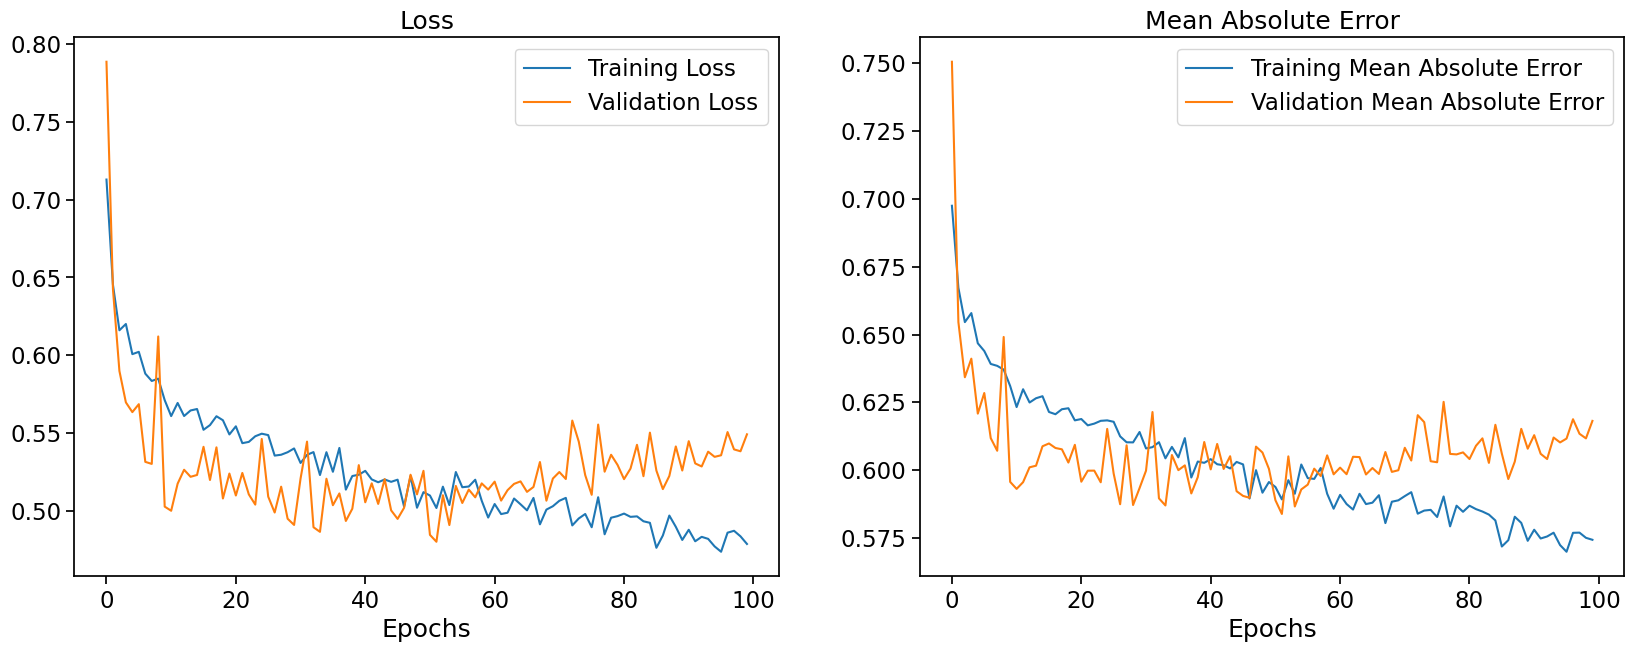

In [97]:
plot_loss_curves(history)

In [75]:
y_pred = model.predict(X_test)

109/109 [==============================] - 0s 1ms/step


In [98]:
model.evaluate(X_test, y_test)

109/109 [==============================] - 0s 2ms/step - loss: 0.5271 - mae: 0.6007


[0.5271334052085876, 0.6006720662117004]

### Model - Linear Regression  - Fine Tuning 

In [106]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(.15),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=['mse'],
              metrics=['mae'])

In [107]:
model.build()

In [108]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Bat  (None, 13)                52        
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 2048)              28672     
                                                                 
 dropout_31 (Dropout)        (None, 2048)              0         
                                                                 
 dense_72 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_32 (Dropout)        (None, 2048)              0         
                                                                 
 dense_73 (Dense)            (None, 2048)              4196352   
                                                     

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=.2)

Epoch 1/100
348/348 [==============================] - 5s 10ms/step - loss: 0.7286 - mae: 0.7105 - val_loss: 0.6692 - val_mae: 0.6699
Epoch 2/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6696 - mae: 0.6804 - val_loss: 0.6153 - val_mae: 0.6479
Epoch 3/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6437 - mae: 0.6681 - val_loss: 0.6036 - val_mae: 0.6371
Epoch 4/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6274 - mae: 0.6604 - val_loss: 0.6246 - val_mae: 0.6686
Epoch 5/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6135 - mae: 0.6540 - val_loss: 0.5488 - val_mae: 0.6205
Epoch 6/100
348/348 [==============================] - 3s 10ms/step - loss: 0.6033 - mae: 0.6504 - val_loss: 0.5882 - val_mae: 0.6381
Epoch 7/100
348/348 [==============================] - 3s 10ms/step - loss: 0.5952 - mae: 0.6441 - val_loss: 0.5344 - val_mae: 0.6118
Epoch 8/100
348/348 [==============================] - 4s 10ms

In [ ]:
plot_loss_curves(history)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
model.evaluate(X_test, y_test)